#  Deep Learning and Image Recognition

## LSTM and GRU Time Series Modeling - Cosine

#### How to use stateful RNNs (LSTM and GRU) are used to model long sequences efficiently.

Keras RNN API is documented here: http://keras.io/layers/recurrent/


Whenever you train or test your LSTM, you first have to build your input matrix X of shape `nb_samples`, `timesteps`, `input_dim` where your `batch_size` divides `nb_samples`. For instance, if `nb_samples=1024` and `batch_size=64`, it means that your model will receive blocks of 64 samples, compute each output (whatever the number of timesteps is for every sample), average the gradients and propagate it to update the parameters vector

By default, Keras shuffles (permutes) the samples in X and the dependencies between $X_i$ and $X_{i+1}$ are lost. Let’s assume there’s no shuffling in our explanation. 

When the model is stateless, Keras allocates an array for the states of size `output_dim` (understand number of cells in your LSTM). At each sequence processing, this state array is reset. 

With the stateful model, all the states are propagated to the next batch.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU
%matplotlib inline

Using TensorFlow backend.


## Generate Training Data

Generating Data..
Input shape: (50000, 1, 1)
Output shape: (50000, 1)


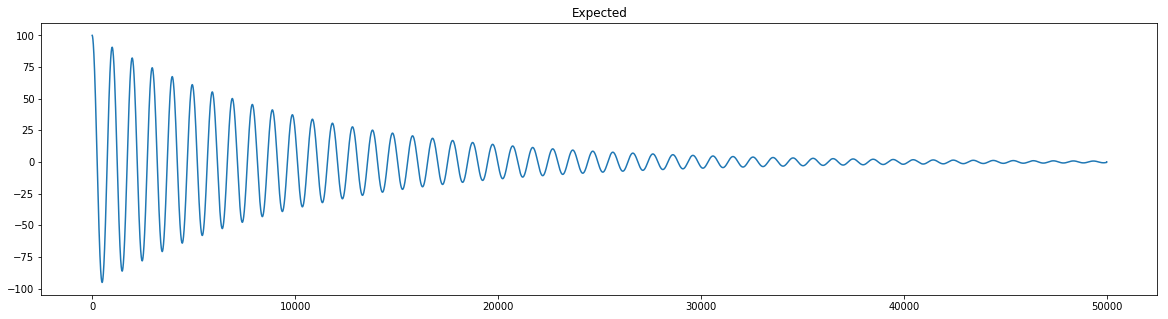

In [2]:
def gen_cosine_amp(amp=100, period=25, x0=0, xn=50000, step=1, k=0.0001):
    """Generates an absolute cosine time series with the amplitude
    exponentially decreasing
    Arguments:
        amp: amplitude of the cosine function
        period: period of the cosine function
        x0: initial x of the time series
        xn: final x of the time series
        step: step of the time series discretization
        k: exponential rate
    """
    cos = np.zeros(((xn - x0) * step, 1, 1))
    for i in range(len(cos)):
        idx = x0 + i * step
        cos[i, 0, 0] = amp * np.cos(idx / (2 * np.pi * period))
        cos[i, 0, 0] = cos[i, 0, 0] * np.exp(-k * idx)
    return cos


# number of elements ahead that are used to make the prediction
lahead = 1

print('Generating Data..')
cos = gen_cosine_amp()
print('Input shape:', cos.shape)

expected_output = np.zeros((len(cos), 1))
for i in range(len(cos) - lahead):
    expected_output[i, 0] = np.mean(cos[i + 1:i + lahead + 1])

#print(cos)
#print(expected_output)
print('Output shape:',expected_output.shape)

#plot training data
plt.figure(figsize=(20,5))
plt.plot(expected_output)
plt.title('Expected')
plt.show()

## LSTM Model

Making a RNN stateful means that the states for the samples of each batch will be reused as initial states for the samples in the next batch.

In [3]:
# since we are using stateful rnn tsteps can be set to 1
tsteps = 1
batch_size = 25
epochs = 10 #Should be higher but will take more time to run

print('Generating Model..')
model = Sequential()

#2 stacked LSTM
model.add(LSTM(50,
               batch_input_shape=(batch_size, tsteps, 1),
               return_sequences=True,
               stateful=True))
model.add(LSTM(50,
               batch_input_shape=(batch_size, tsteps, 1),
               return_sequences=False,
               stateful=True))
model.add(Dense(1))
model.compile(loss='mse', optimizer='rmsprop')

print('Training')
for i in range(epochs):
    print('Epoch', i, '/', epochs)
    model.fit(cos,
              expected_output,
              batch_size=batch_size,
              verbose=1,
              epochs=1,
              shuffle=False)
    model.reset_states()


Generating Model..
Training
Epoch 0 / 10
Epoch 1/1
50000/50000 [==============================] - 27s 544us/step - loss: 382.2870
Epoch 1 / 10
Epoch 1/1
50000/50000 [==============================] - 25s 505us/step - loss: 221.0542
Epoch 2 / 10
Epoch 1/1
50000/50000 [==============================] - 25s 506us/step - loss: 244.7563
Epoch 3 / 10
Epoch 1/1
50000/50000 [==============================] - 25s 503us/step - loss: 170.0100
Epoch 4 / 10
Epoch 1/1
50000/50000 [==============================] - 25s 500us/step - loss: 126.8683
Epoch 5 / 10
Epoch 1/1
50000/50000 [==============================] - 25s 509us/step - loss: 141.6006
Epoch 6 / 10
Epoch 1/1
50000/50000 [==============================] - 26s 517us/step - loss: 104.6025
Epoch 7 / 10
Epoch 1/1
50000/50000 [==============================] - 24s 488us/step - loss: 53.0514
Epoch 8 / 10
Epoch 1/1
50000/50000 [==============================] - 25s 505us/step - loss: 44.6482
Epoch 9 / 10
Epoch 1/1
50000/50000 [====================

## Check Model

In [4]:
print("Model Parameters :", model.count_params())
print("Output Shape :", model.output_shape)
#print("Model Weights :", model.get_weights())

Model Parameters : 30651
Output Shape : (25, 1)


In [5]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (25, 1, 50)               10400     
_________________________________________________________________
lstm_2 (LSTM)                (25, 50)                  20200     
_________________________________________________________________
dense_1 (Dense)              (25, 1)                   51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


## Predict model output

In [6]:
print('Predicting')
predicted_output = model.predict(cos, batch_size=batch_size)

Predicting


## Plot results

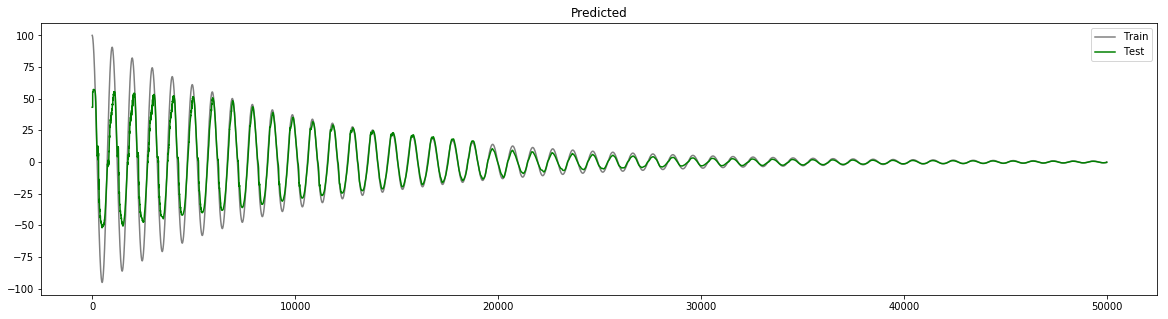

In [7]:
plt.figure(figsize=(20,5))
plt.plot(expected_output, "grey", label='Train')
plt.plot(predicted_output, "green", label='Test')
plt.title('Predicted')
plt.legend()
plt.show()

## GRU Model

In [23]:
# since we are using stateful rnn tsteps can be set to 1
tsteps = 1
batch_size = 25
epochs = 20 #Should be higher but will take more time to run

print('Generating Model..')
model = Sequential()

#2 stacked GRU
model.add(GRU(30,
               batch_input_shape=(batch_size, tsteps, 1),
               return_sequences=True,
               stateful=True))
model.add(GRU(30,
               batch_input_shape=(batch_size, tsteps, 1),
               return_sequences=False,
               stateful=True))
model.add(Dense(1))
model.compile(loss='mse', optimizer='rmsprop')

print('Training')
for i in range(epochs):
    print('Epoch', i, '/', epochs)
    model.fit(cos,
              expected_output,
              batch_size=batch_size,
              verbose=1,
              epochs=1,
              shuffle=False)
    model.reset_states()

Generating Model..
Training
Epoch 0 / 20
Epoch 1/1
50000/50000 [==============================] - 24s 490us/step - loss: 317.6446
Epoch 1 / 20
Epoch 1/1
50000/50000 [==============================] - 23s 452us/step - loss: 178.2272
Epoch 2 / 20
Epoch 1/1
50000/50000 [==============================] - 24s 478us/step - loss: 116.1531
Epoch 3 / 20
Epoch 1/1
50000/50000 [==============================] - 23s 457us/step - loss: 80.1460
Epoch 4 / 20
Epoch 1/1
50000/50000 [==============================] - 22s 446us/step - loss: 63.0380
Epoch 5 / 20
Epoch 1/1
50000/50000 [==============================] - 23s 454us/step - loss: 49.8709
Epoch 6 / 20
Epoch 1/1
50000/50000 [==============================] - 23s 459us/step - loss: 41.8453
Epoch 7 / 20
Epoch 1/1
50000/50000 [==============================] - 23s 455us/step - loss: 33.1942
Epoch 8 / 20
Epoch 1/1
50000/50000 [==============================] - 24s 472us/step - loss: 26.9094
Epoch 9 / 20
Epoch 1/1
50000/50000 [========================

## Check Model

In [24]:
print("Model Parameters :", model.count_params())
print("Output Shape :", model.output_shape)
#print("Model Weights :", model.get_weights())

Model Parameters : 8401
Output Shape : (25, 1)


In [25]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_7 (GRU)                  (25, 1, 30)               2880      
_________________________________________________________________
gru_8 (GRU)                  (25, 30)                  5490      
_________________________________________________________________
dense_5 (Dense)              (25, 1)                   31        
Total params: 8,401
Trainable params: 8,401
Non-trainable params: 0
_________________________________________________________________


## Predict model output

In [26]:
print('Predicting')
predicted_output = model.predict(cos, batch_size=batch_size)

Predicting


## Plot results

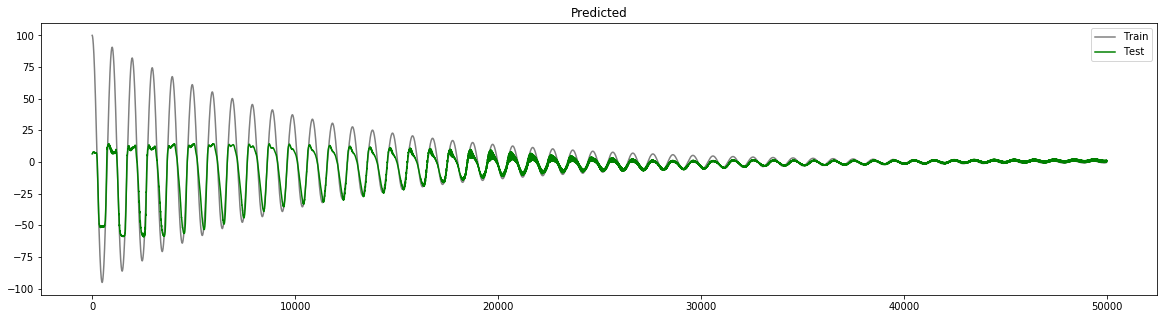

In [27]:
plt.figure(figsize=(20,5))
plt.plot(expected_output, "grey", label='Train')
plt.plot(predicted_output, "green", label='Test')
plt.title('Predicted')
plt.legend()
plt.show()